In [ ]:
pip install tensorflow

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy as sp
from random import uniform

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, make_scorer, f1_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer, QuantileTransformer
from sklearn.pipeline import Pipeline, TransformerMixin, make_pipeline
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.decomposition import PCA 
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Ridge
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier 
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, ExtraTreesClassifier, IsolationForest
from sklearn.svm import SVC, LinearSVC

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
#os.chdir("/Users/lexi/Desktop/Mini_Project")
features_train = pd.read_csv("dengue_features_train.csv", index_col= [0, 1, 2])
labels_train = pd.read_csv("dengue_labels_train.csv", index_col= [0, 1, 2])
features_test = pd.read_csv("dengue_features_test.csv", index_col= [0, 1, 2])
submission = pd.read_csv("submission_format.csv")

print('The dimension of the train dataset is:', features_train.shape)
print('The dimension of the test dataset is:', features_test.shape)

seed = 42

The dimension of the train dataset is: (1456, 21)
The dimension of the test dataset is: (416, 21)


In [3]:
features_train.dtypes

week_start_date                           object
ndvi_ne                                  float64
ndvi_nw                                  float64
ndvi_se                                  float64
ndvi_sw                                  float64
precipitation_amt_mm                     float64
reanalysis_air_temp_k                    float64
reanalysis_avg_temp_k                    float64
reanalysis_dew_point_temp_k              float64
reanalysis_max_air_temp_k                float64
reanalysis_min_air_temp_k                float64
reanalysis_precip_amt_kg_per_m2          float64
reanalysis_relative_humidity_percent     float64
reanalysis_sat_precip_amt_mm             float64
reanalysis_specific_humidity_g_per_kg    float64
reanalysis_tdtr_k                        float64
station_avg_temp_c                       float64
station_diur_temp_rng_c                  float64
station_max_temp_c                       float64
station_min_temp_c                       float64
station_precip_mm   

In [5]:
def df_info(df):
    info_df = pd.DataFrame(df.dtypes, columns=['dtypes'])
    info_df["Nan"] = df.isna().sum()
    info_df["Nan %"] = df.isna().sum() / len(df)
    info_df["Nunique"] = df.nunique()
    info_df["count"] = df.count()
    print(f"Shape: {df.shape}")
    return info_df.style.background_gradient(cmap='Reds')

df_info(features_train)

Shape: (1456, 21)


,dtypes,Nan,Nan %,Nunique,count
week_start_date,object,0,0.000000,1049,1456
ndvi_ne,float64,194,0.133242,1214,1262
ndvi_nw,float64,52,0.035714,1365,1404
ndvi_se,float64,22,0.015110,1395,1434
ndvi_sw,float64,22,0.015110,1388,1434
precipitation_amt_mm,float64,13,0.008929,1157,1443
reanalysis_air_temp_k,float64,10,0.006868,1176,1446
reanalysis_avg_temp_k,float64,10,0.006868,600,1446
reanalysis_dew_point_temp_k,float64,10,0.006868,1180,1446
reanalysis_max_air_temp_k,float64,10,0.006868,141,1446


In [ ]:
#train.head(20)

In [17]:
sj_train_features = features_train.loc['sj']
iq_train_features = features_train.loc['iq']

sj_test_features = features_test.loc['sj']
iq_test_features = features_test.loc['iq']

sj_train_labels = labels_train.loc['sj']
iq_train_labels = labels_train.loc['iq']


In [18]:
sj_train_features.shape

(936, 21)

In [19]:
iq_train_features.shape

(520, 21)

In [20]:
#Data Cleaning
sj_train_features.isnull().sum()

week_start_date                            0
ndvi_ne                                  191
ndvi_nw                                   49
ndvi_se                                   19
ndvi_sw                                   19
precipitation_amt_mm                       9
reanalysis_air_temp_k                      6
reanalysis_avg_temp_k                      6
reanalysis_dew_point_temp_k                6
reanalysis_max_air_temp_k                  6
reanalysis_min_air_temp_k                  6
reanalysis_precip_amt_kg_per_m2            6
reanalysis_relative_humidity_percent       6
reanalysis_sat_precip_amt_mm               9
reanalysis_specific_humidity_g_per_kg      6
reanalysis_tdtr_k                          6
station_avg_temp_c                         6
station_diur_temp_rng_c                    6
station_max_temp_c                         6
station_min_temp_c                         6
station_precip_mm                          6
dtype: int64

In [21]:
iq_train_features.isnull().sum()

week_start_date                           0
ndvi_ne                                   3
ndvi_nw                                   3
ndvi_se                                   3
ndvi_sw                                   3
precipitation_amt_mm                      4
reanalysis_air_temp_k                     4
reanalysis_avg_temp_k                     4
reanalysis_dew_point_temp_k               4
reanalysis_max_air_temp_k                 4
reanalysis_min_air_temp_k                 4
reanalysis_precip_amt_kg_per_m2           4
reanalysis_relative_humidity_percent      4
reanalysis_sat_precip_amt_mm              4
reanalysis_specific_humidity_g_per_kg     4
reanalysis_tdtr_k                         4
station_avg_temp_c                       37
station_diur_temp_rng_c                  37
station_max_temp_c                       14
station_min_temp_c                        8
station_precip_mm                        16
dtype: int64

In [22]:
submission.isnull().sum()

city           0
year           0
weekofyear     0
total_cases    0
dtype: int64

In [23]:
labels_train.isnull().sum()

total_cases    0
dtype: int64

In [24]:
sj_train_features.fillna(method='ffill', inplace=True)
iq_train_features.fillna(method='ffill', inplace=True)

C:\Users\Oscar\AppData\Local\Temp\ipykernel_23392\890142997.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sj_train_features.fillna(method='ffill', inplace=True)
C:\Users\Oscar\AppData\Local\Temp\ipykernel_23392\890142997.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sj_train_features.fillna(method='ffill', inplace=True)
C:\Users\Oscar\AppData\Local\Temp\ipykernel_23392\890142997.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  iq_train_features.fillna(method='ffill', inplace=True)
C:\Users\Oscar\AppData\Local\Temp\ipykernel_23392\890142997.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy

Text(0.5, 0, 'reanalysis_dew_point_temp_k')

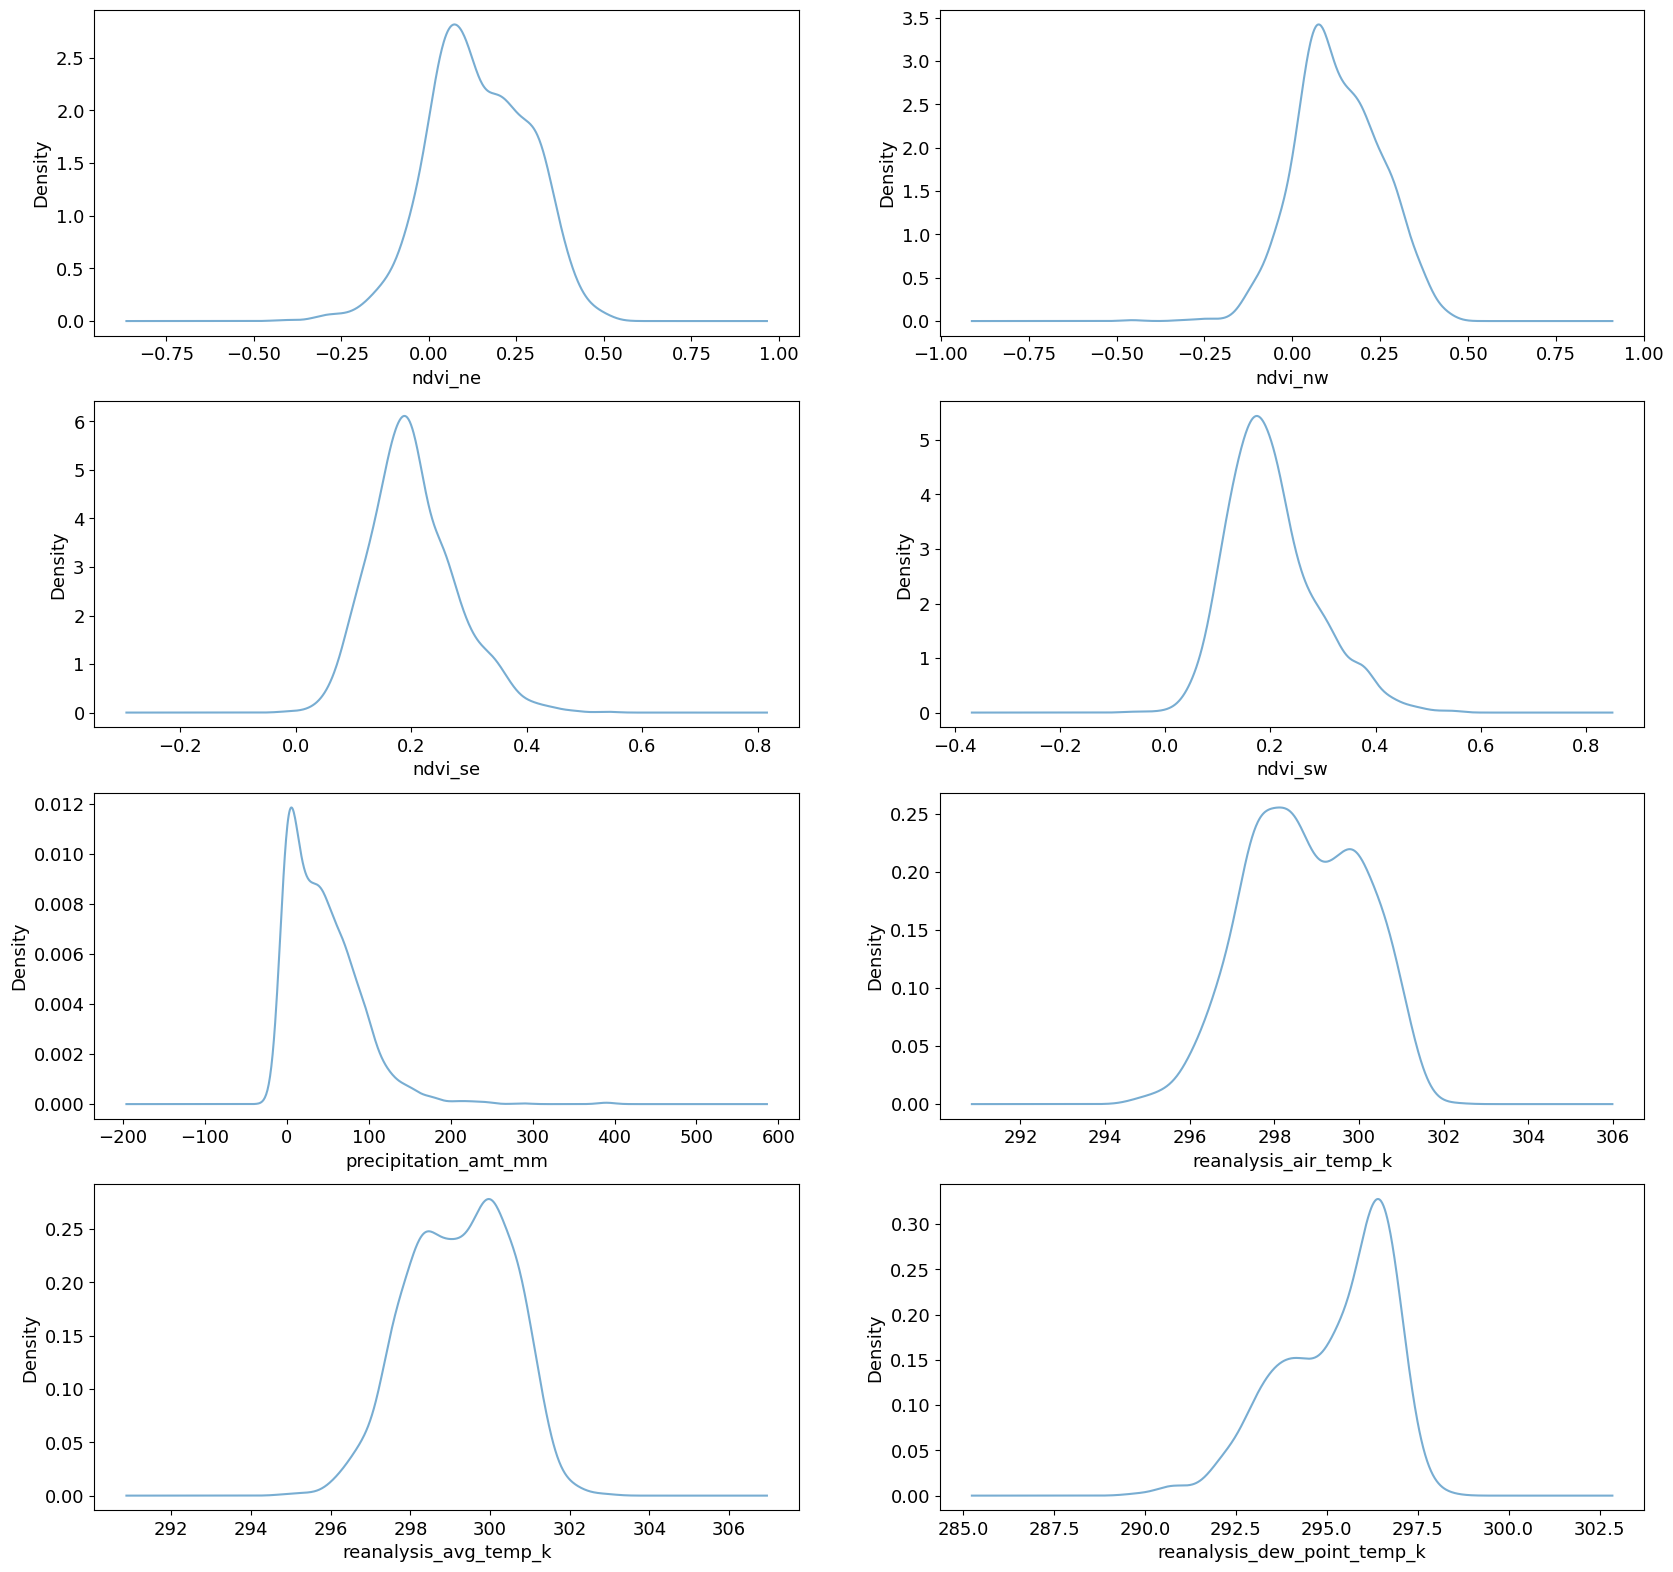

In [25]:
plt.rc("font", size=13)
plt.figure(figsize=(20,50))
alpha=0.6

#--------------------------------------------------#

ax1 = plt.subplot2grid((10,2), (0,0))
features_train.ndvi_ne.plot(kind="kde",alpha=alpha)
ax1.set_xlabel("ndvi_ne")

ax2 = plt.subplot2grid((10,2),(0,1))
features_train.ndvi_nw.plot(kind="kde",alpha=alpha)
ax2.set_xlabel("ndvi_nw")


ax3 = plt.subplot2grid((10,2),(1,0))
features_train.ndvi_se.plot(kind="kde",alpha=alpha)
ax3.set_xlabel("ndvi_se")

ax4 = plt.subplot2grid((10,2),(1,1))
features_train.ndvi_sw.plot(kind="kde",alpha=alpha)
ax4.set_xlabel("ndvi_sw")


ax5 = plt.subplot2grid((10,2),(2,0))
features_train.precipitation_amt_mm.plot(kind="kde",alpha=alpha)
ax5.set_xlabel("precipitation_amt_mm")

ax6 = plt.subplot2grid((10,2),(2,1))
features_train.reanalysis_air_temp_k.plot(kind="kde",alpha=alpha)
ax6.set_xlabel("reanalysis_air_temp_k")
ax7 = plt.subplot2grid((10,2),(3,0))
features_train.reanalysis_avg_temp_k.plot(kind="kde",alpha=alpha)
ax7.set_xlabel("reanalysis_avg_temp_k")

ax8 = plt.subplot2grid((10,2),(3,1))
features_train.reanalysis_dew_point_temp_k.plot(kind="kde",alpha=alpha)
ax8.set_xlabel("reanalysis_dew_point_temp_k")

<Axes: xlabel='total_cases'>

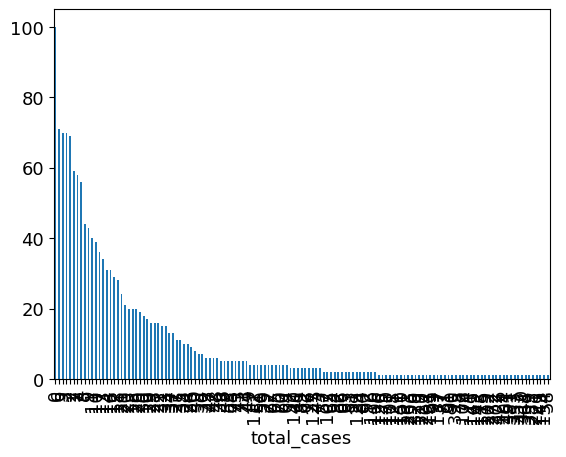

In [29]:
plot_df = labels_train["total_cases"].value_counts()
plot_df.plot(kind="bar")

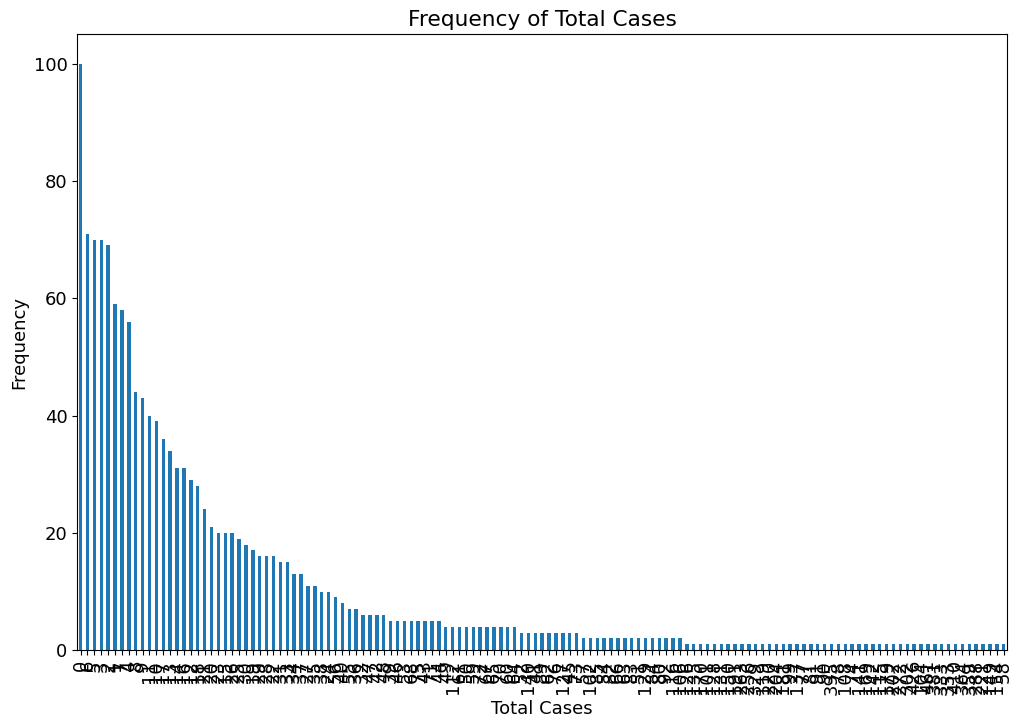

In [31]:
import matplotlib.pyplot as plt

plot_df = labels_train["total_cases"].value_counts()
plt.figure(figsize=(12, 8))  # Larger figsize for better visibility
plot_df.plot(kind="bar")
plt.xlabel("Total Cases")
plt.ylabel("Frequency")
plt.title("Frequency of Total Cases")
plt.show()


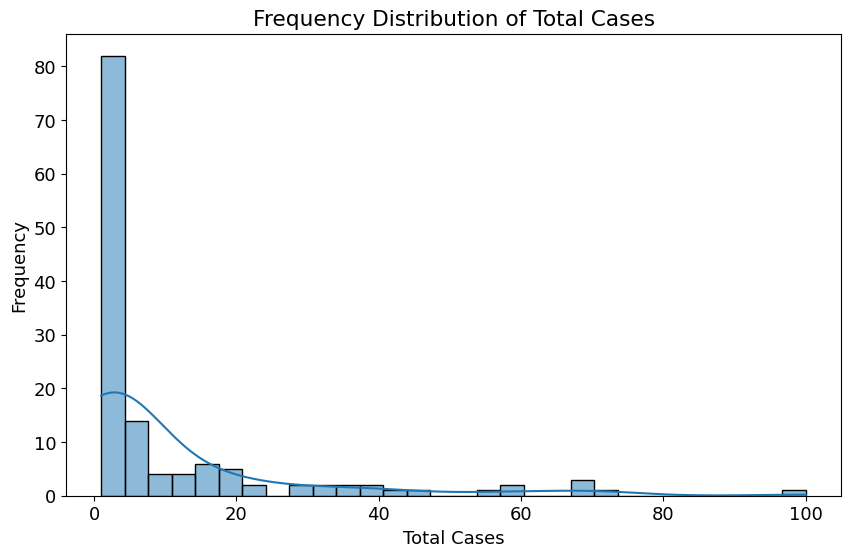

In [32]:
import seaborn as sns

plot_df = labels_train["total_cases"].value_counts()
plt.figure(figsize=(10, 6))
sns.histplot(data=plot_df, bins=30, kde=True)
plt.xlabel("Total Cases")
plt.ylabel("Frequency")
plt.title("Frequency Distribution of Total Cases")
plt.show()


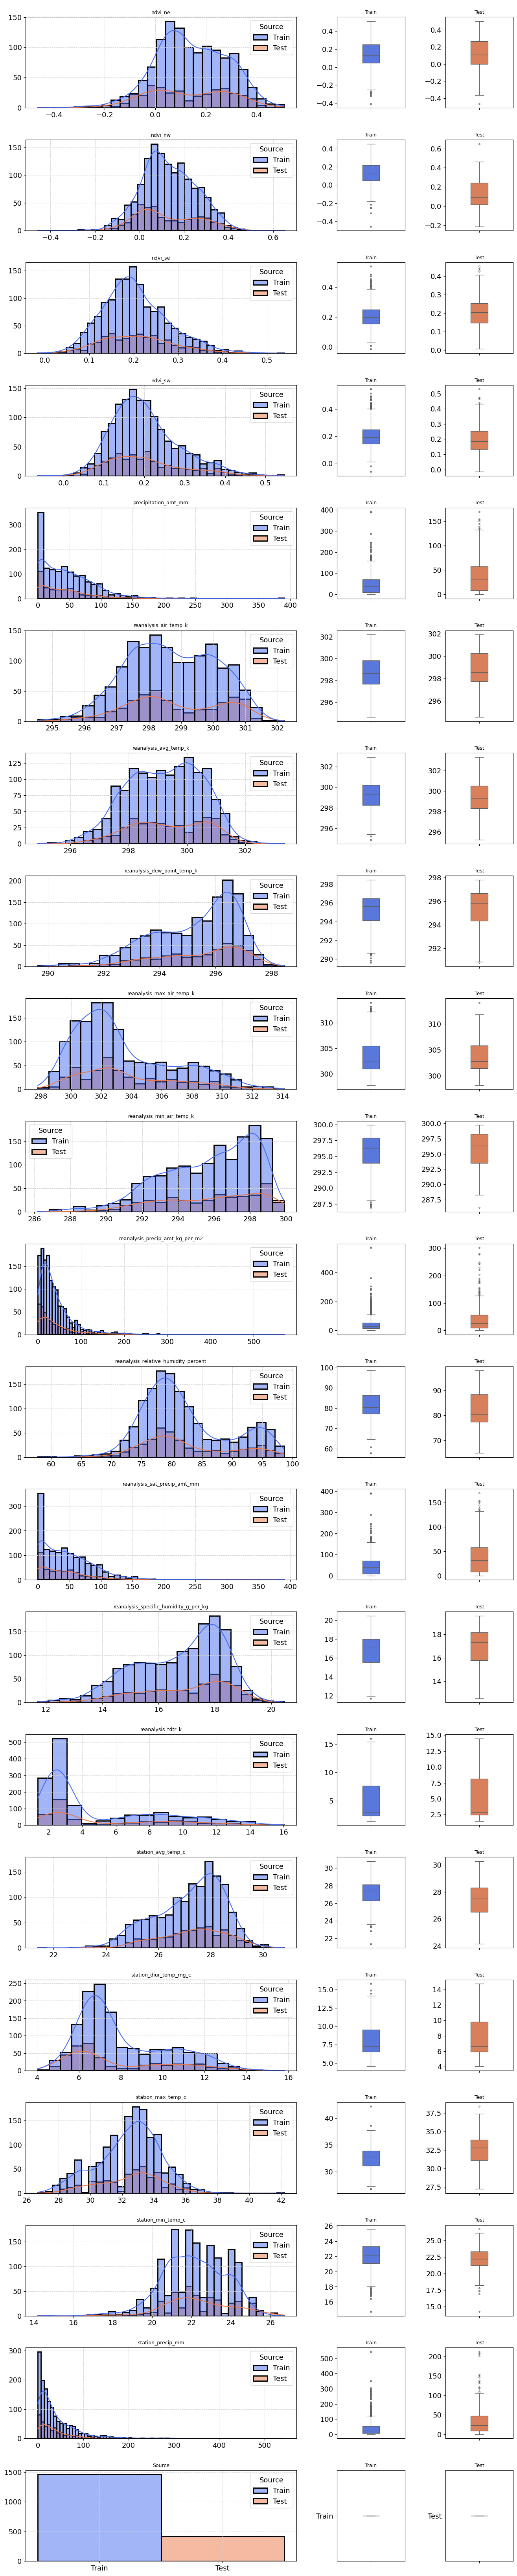

In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

features_train = pd.read_csv("dengue_features_train.csv", index_col=[0, 1, 2])
features_test = pd.read_csv("dengue_features_test.csv", index_col=[0, 1, 2])

# Combine train and test features for visualization
df = pd.concat([features_train.select_dtypes(include=['int', 'float']).assign(Source='Train'),
                features_test.select_dtypes(include=['int', 'float']).assign(Source='Test')],
               ignore_index=True)

# Use of more advanced artistic matplotlib interface (see the axes)
fig, axes = plt.subplots(len(df.columns), 3, figsize=(16, len(df.columns) * 4),
                         gridspec_kw={'hspace': 0.35, 'wspace': 0.3, 'width_ratios': [0.80, 0.20, 0.20]})

for i, col in enumerate(df.columns):
    ax = axes[i, 0]
    sns.histplot(data=df, x=col, hue='Source', palette=['#456cf0', '#ed7647'], kde=True, linewidth=2.1,
                 multiple='layer', ax=ax)  # Use seaborn's histplot with KDE
    ax.set_title(f"\n{col}", fontsize=9)
    ax.grid(visible=True, which='both', linestyle='--', color='lightgrey', linewidth=0.75)
    ax.set(xlabel='', ylabel='')

    ax = axes[i, 1]
    sns.boxplot(data=df.loc[df.Source == 'Train', [col]], y=col, width=0.25, linewidth=0.90, fliersize=2.25,
                color='#456cf0', ax=ax)
    ax.set(xlabel='', ylabel='')
    ax.set_title("Train", fontsize=9)

    ax = axes[i, 2]
    sns.boxplot(data=df.loc[df.Source == 'Test', [col]], y=col, width=0.25, linewidth=0.90, fliersize=2.25,
                color='#ed7647', ax=ax)
    ax.set(xlabel='', ylabel='')
    ax.set_title("Test", fontsize=9)

plt.show()


In [37]:
import matplotlib.pyplot as plt

def create_stacked_histogram(column, target, train_data, range=(0, 500)):

    # Create subsets for each label
    label_1_data = train_data[train_data[target] == True][column]
    label_0_data = train_data[train_data[target] == False][column]

    # Create stacked histogram for age
    plt.figure(figsize=(8, 8))  # Corrected figsize
    plt.hist([label_1_data, label_0_data],
             bins=50,
             label=['Defected', 'Not Defected'],
             stacked=True,
             edgecolor='black',
             range=range
             )
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

# Assuming 'train' is your DataFrame containing the data
for col in labels_train.drop('total_cases', axis=1).columns:
    create_stacked_histogram(col, 'total_cases', train, range=(0, 250))


In [38]:
import pandas as pd

# Load data
features_train = pd.read_csv("dengue_features_train.csv", index_col=[0, 1, 2])
labels_train = pd.read_csv("dengue_labels_train.csv", index_col=[0, 1, 2])
features_test = pd.read_csv("dengue_features_test.csv", index_col=[0, 1, 2])
submission = pd.read_csv("submission_format.csv")

# Display information about the loaded datasets
print("Features Train:")
print(features_train.info())

print("\nLabels Train:")
print(labels_train.info())

print("\nFeatures Test:")
print(features_test.info())

print("\nSubmission Format:")
print(submission.info())


Features Train:
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1456 entries, ('sj', 1990, 18) to ('iq', 2010, 25)
Data columns (total 21 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   week_start_date                        1456 non-null   object 
 1   ndvi_ne                                1262 non-null   float64
 2   ndvi_nw                                1404 non-null   float64
 3   ndvi_se                                1434 non-null   float64
 4   ndvi_sw                                1434 non-null   float64
 5   precipitation_amt_mm                   1443 non-null   float64
 6   reanalysis_air_temp_k                  1446 non-null   float64
 7   reanalysis_avg_temp_k                  1446 non-null   float64
 8   reanalysis_dew_point_temp_k            1446 non-null   float64
 9   reanalysis_max_air_temp_k              1446 non-null   float64
 10  reanalysis_min_air_temp_k    

In [48]:
labels_train.columns

Index(['total_cases'], dtype='object')

In [47]:
features_train.columns

Index(['week_start_date', 'ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw',
       'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm'],
      dtype='object')

In [53]:
submission.columns

Index(['city', 'year', 'weekofyear', 'total_cases'], dtype='object')

In [ ]:
import matplotlib.pyplot as plt

def create_stacked_histogram(column, target, train_data, range=(0, 500)):

    # Create subsets for each label
    label_1_data = train_data[train_data[target] == True][column]
    label_0_data = train_data[train_data[target] == False][column]

    # Create stacked histogram
    plt.figure(figsize=(8, 8))
    plt.hist([label_1_data, label_0_data],
             bins=50,
             label=['Defected', 'Not Defected'],
             stacked=True,
             edgecolor='black',
             range=range
             )
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()


for col in submission.columns:
    if col not in ['city', 'year', 'weekofyear', 'total_cases']:
        create_stacked_histogram(col, 'total_cases', submission, range=(0, 250))



In [55]:
print(submission.head())


  city  year  weekofyear  total_cases
0   sj  2008          18            0
1   sj  2008          19            0
2   sj  2008          20            0
3   sj  2008          21            0
4   sj  2008          22            0


In [60]:
print(submission.columns)


Index(['city', 'year', 'weekofyear', 'total_cases'], dtype='object')


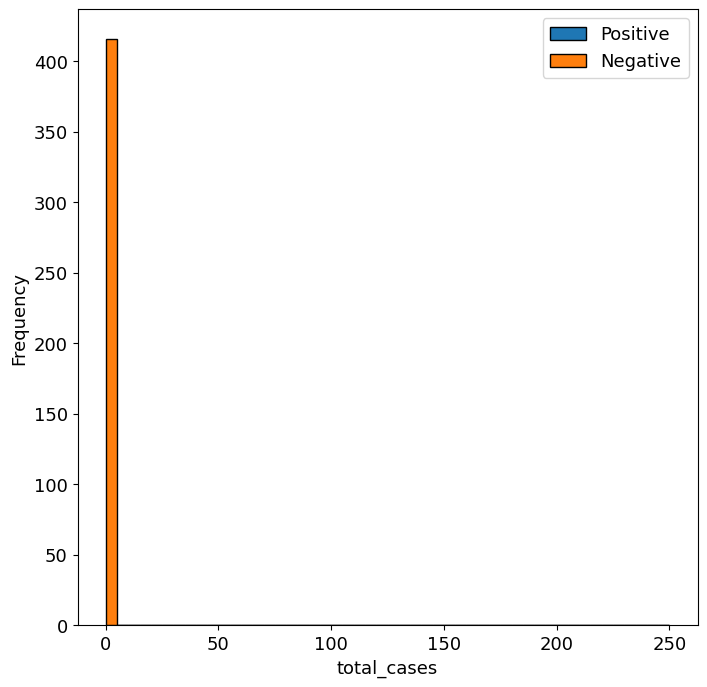

In [ ]:
def create_stacked_histogram(column, target, train_data, range=(0, 500)):
    # Created subsets for each label
    label_1_data = train_data[train_data[target] > 0][column]
    label_0_data = train_data[train_data[target] == 0][column]

    # Created stacked histogram
    plt.figure(figsize=(8, 8))
    plt.hist([label_1_data, label_0_data],
             bins=50,
             label=['Positive', 'Negative'],
             stacked=True,
             edgecolor='black',
             range=range)
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

create_stacked_histogram('total_cases', 'total_cases', submission, range=(0, 250))



Text(0.5, 0, 'station_precip_mm')

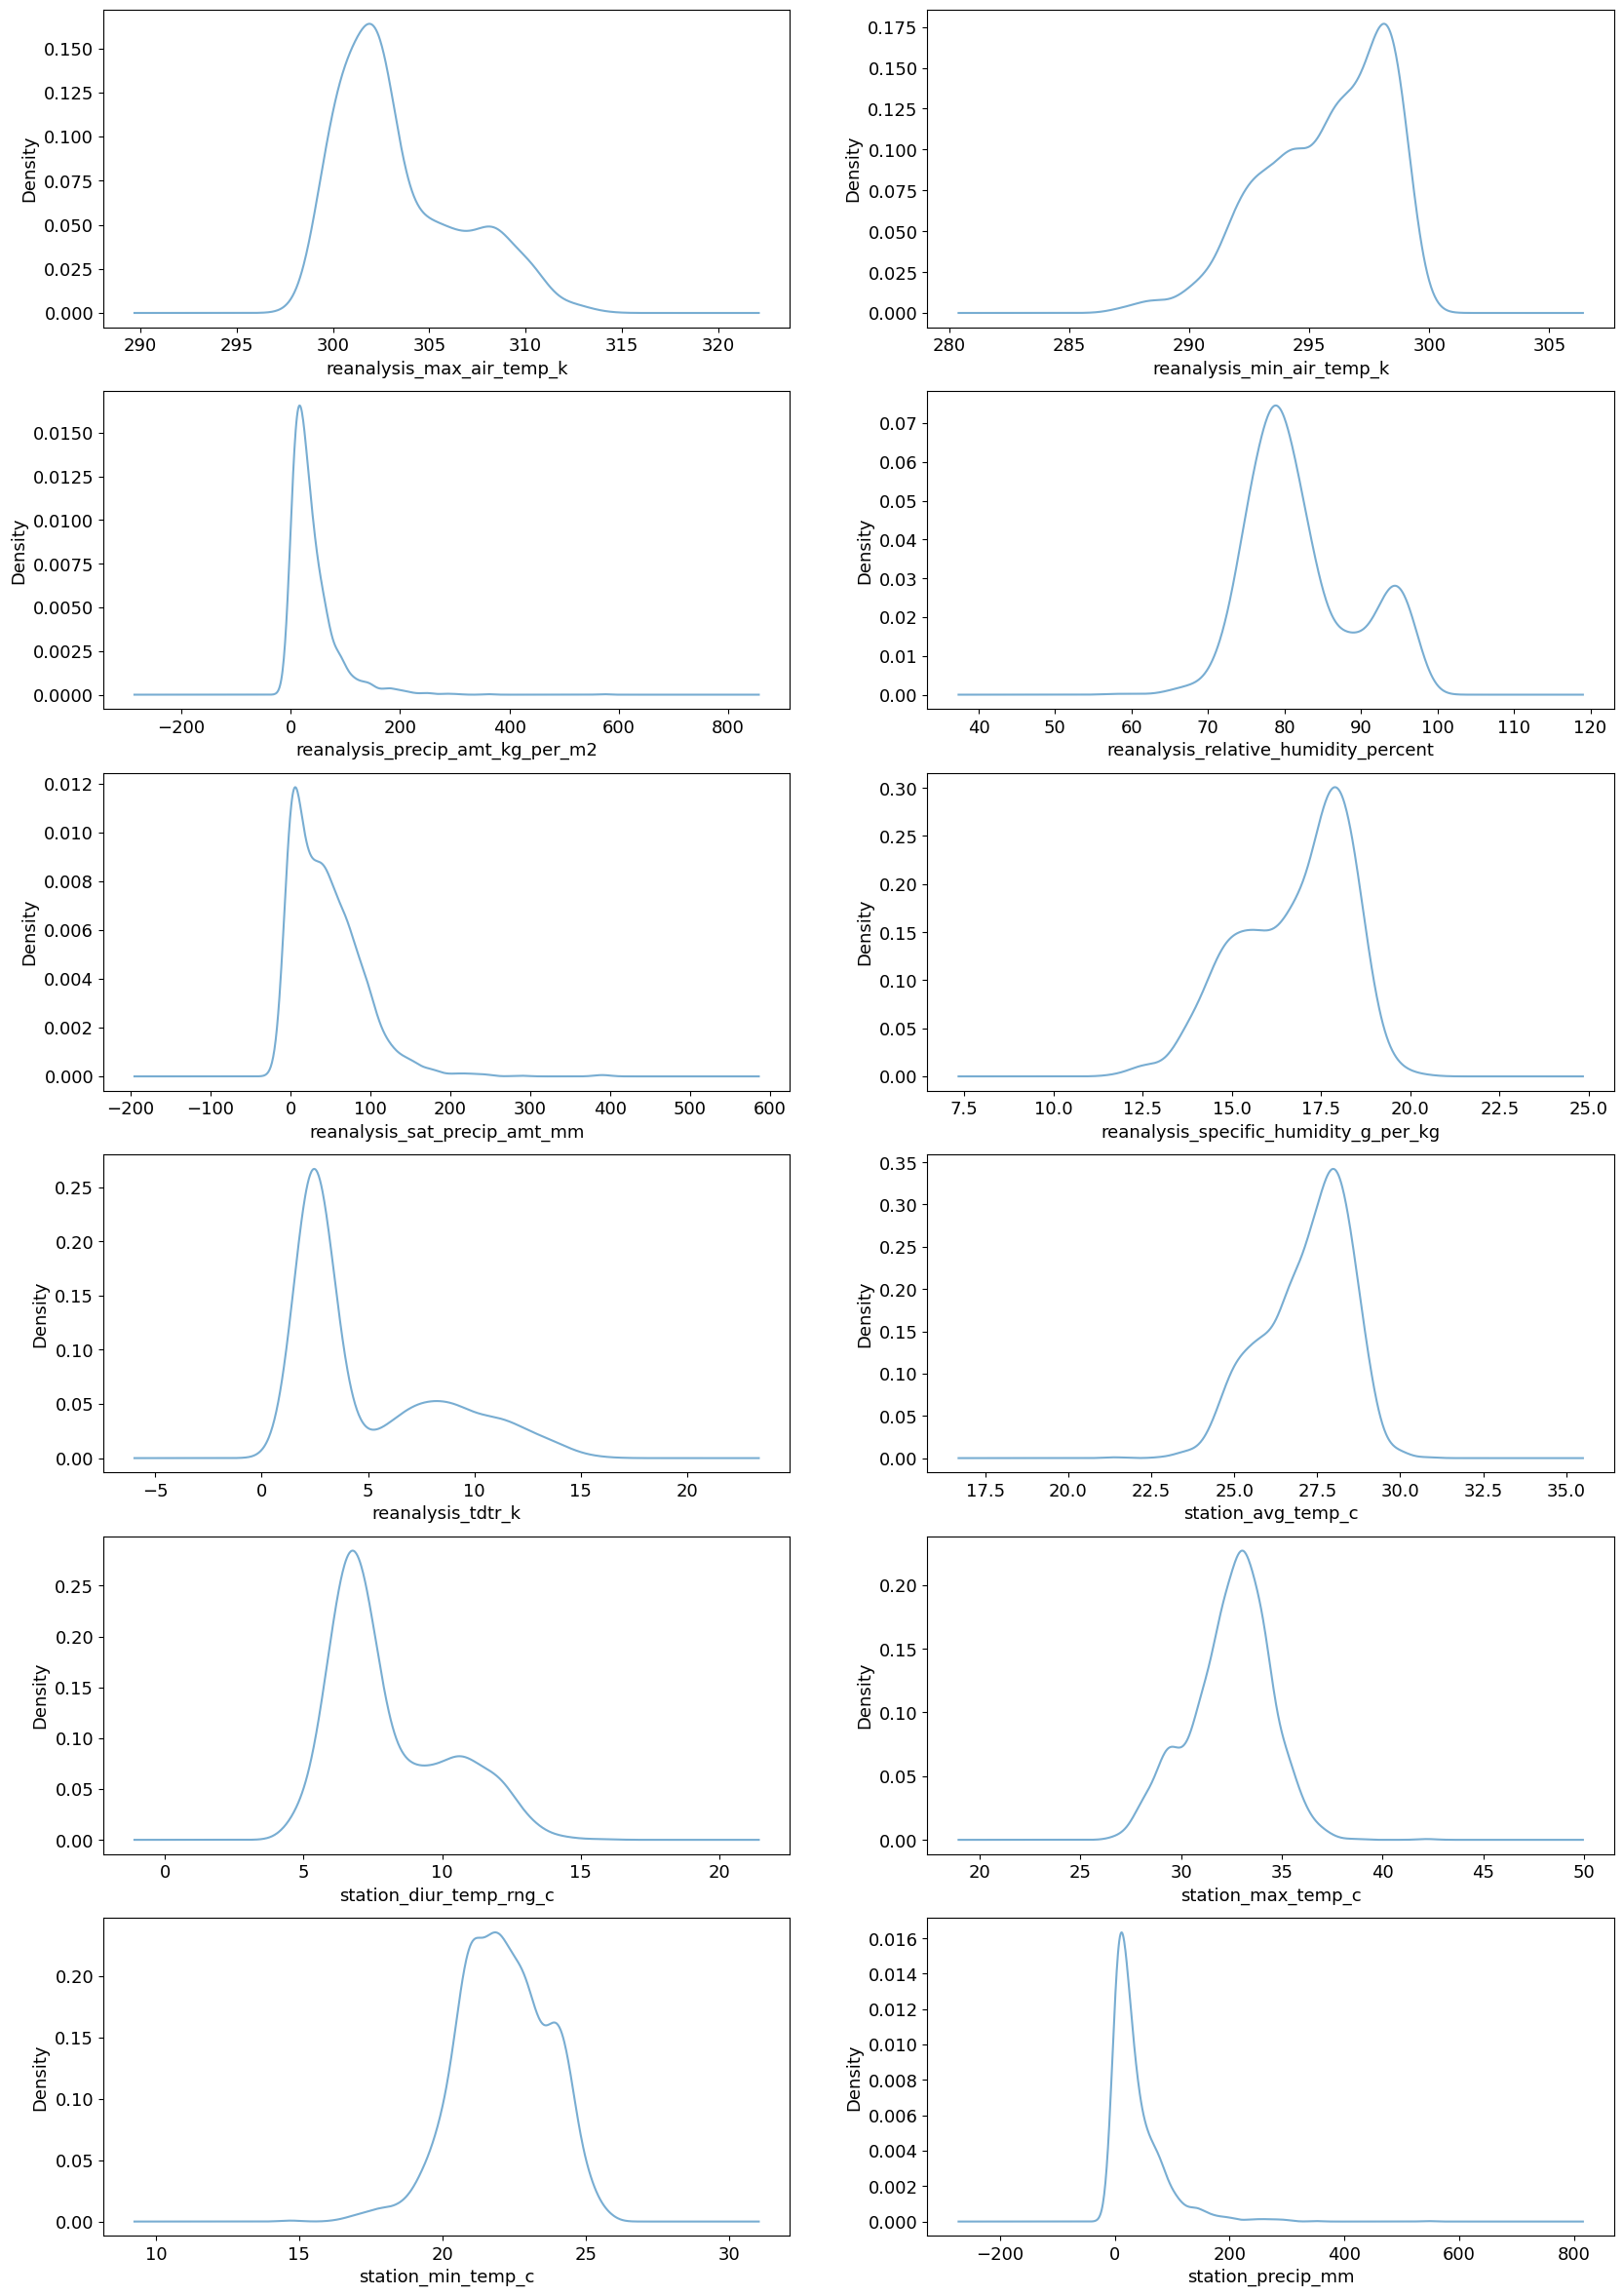

In [82]:
plt.rc("font", size=13)
plt.figure(figsize=(20,50))
alpha=0.6

ax9 = plt.subplot2grid((10,2),(4,0))
features_train.reanalysis_max_air_temp_k.plot(kind="kde",alpha=alpha)
ax9.set_xlabel("reanalysis_max_air_temp_k")

ax10 = plt.subplot2grid((10,2),(4,1))
features_train.reanalysis_min_air_temp_k.plot(kind="kde",alpha=alpha)
ax10.set_xlabel("reanalysis_min_air_temp_k")


ax11 = plt.subplot2grid((10,2),(5,0))
features_train.reanalysis_precip_amt_kg_per_m2.plot(kind="kde",alpha=alpha)
ax11.set_xlabel("reanalysis_precip_amt_kg_per_m2")

ax12 = plt.subplot2grid((10,2),(5,1))
features_train.reanalysis_relative_humidity_percent.plot(kind="kde",alpha=alpha)
ax12.set_xlabel("reanalysis_relative_humidity_percent")


ax13 = plt.subplot2grid((10,2),(6,0))
features_train.reanalysis_sat_precip_amt_mm.plot(kind="kde",alpha=alpha)
ax13.set_xlabel("reanalysis_sat_precip_amt_mm")

ax14 = plt.subplot2grid((10,2),(6,1))
features_train.reanalysis_specific_humidity_g_per_kg.plot(kind="kde",alpha=alpha)
ax14.set_xlabel("reanalysis_specific_humidity_g_per_kg")


ax15 = plt.subplot2grid((10,2),(7,0))
features_train.reanalysis_tdtr_k.plot(kind="kde",alpha=alpha)
ax15.set_xlabel("reanalysis_tdtr_k")

ax16 = plt.subplot2grid((10,2),(7,1))
features_train.station_avg_temp_c.plot(kind="kde",alpha=alpha)
ax16.set_xlabel("station_avg_temp_c")


ax17 = plt.subplot2grid((10,2),(8,0))
features_train.station_diur_temp_rng_c.plot(kind="kde",alpha=alpha)
ax17.set_xlabel("station_diur_temp_rng_c")

ax18 = plt.subplot2grid((10,2),(8,1))
features_train.station_max_temp_c.plot(kind="kde",alpha=alpha)
ax18.set_xlabel("station_max_temp_c")


ax19 = plt.subplot2grid((10,2),(9,0))
features_train.station_min_temp_c.plot(kind="kde",alpha=alpha)
ax19.set_xlabel("station_min_temp_c")

ax20 = plt.subplot2grid((10,2),(9,1))
features_train.station_precip_mm.plot(kind="kde",alpha=alpha)
ax20.set_xlabel("station_precip_mm")

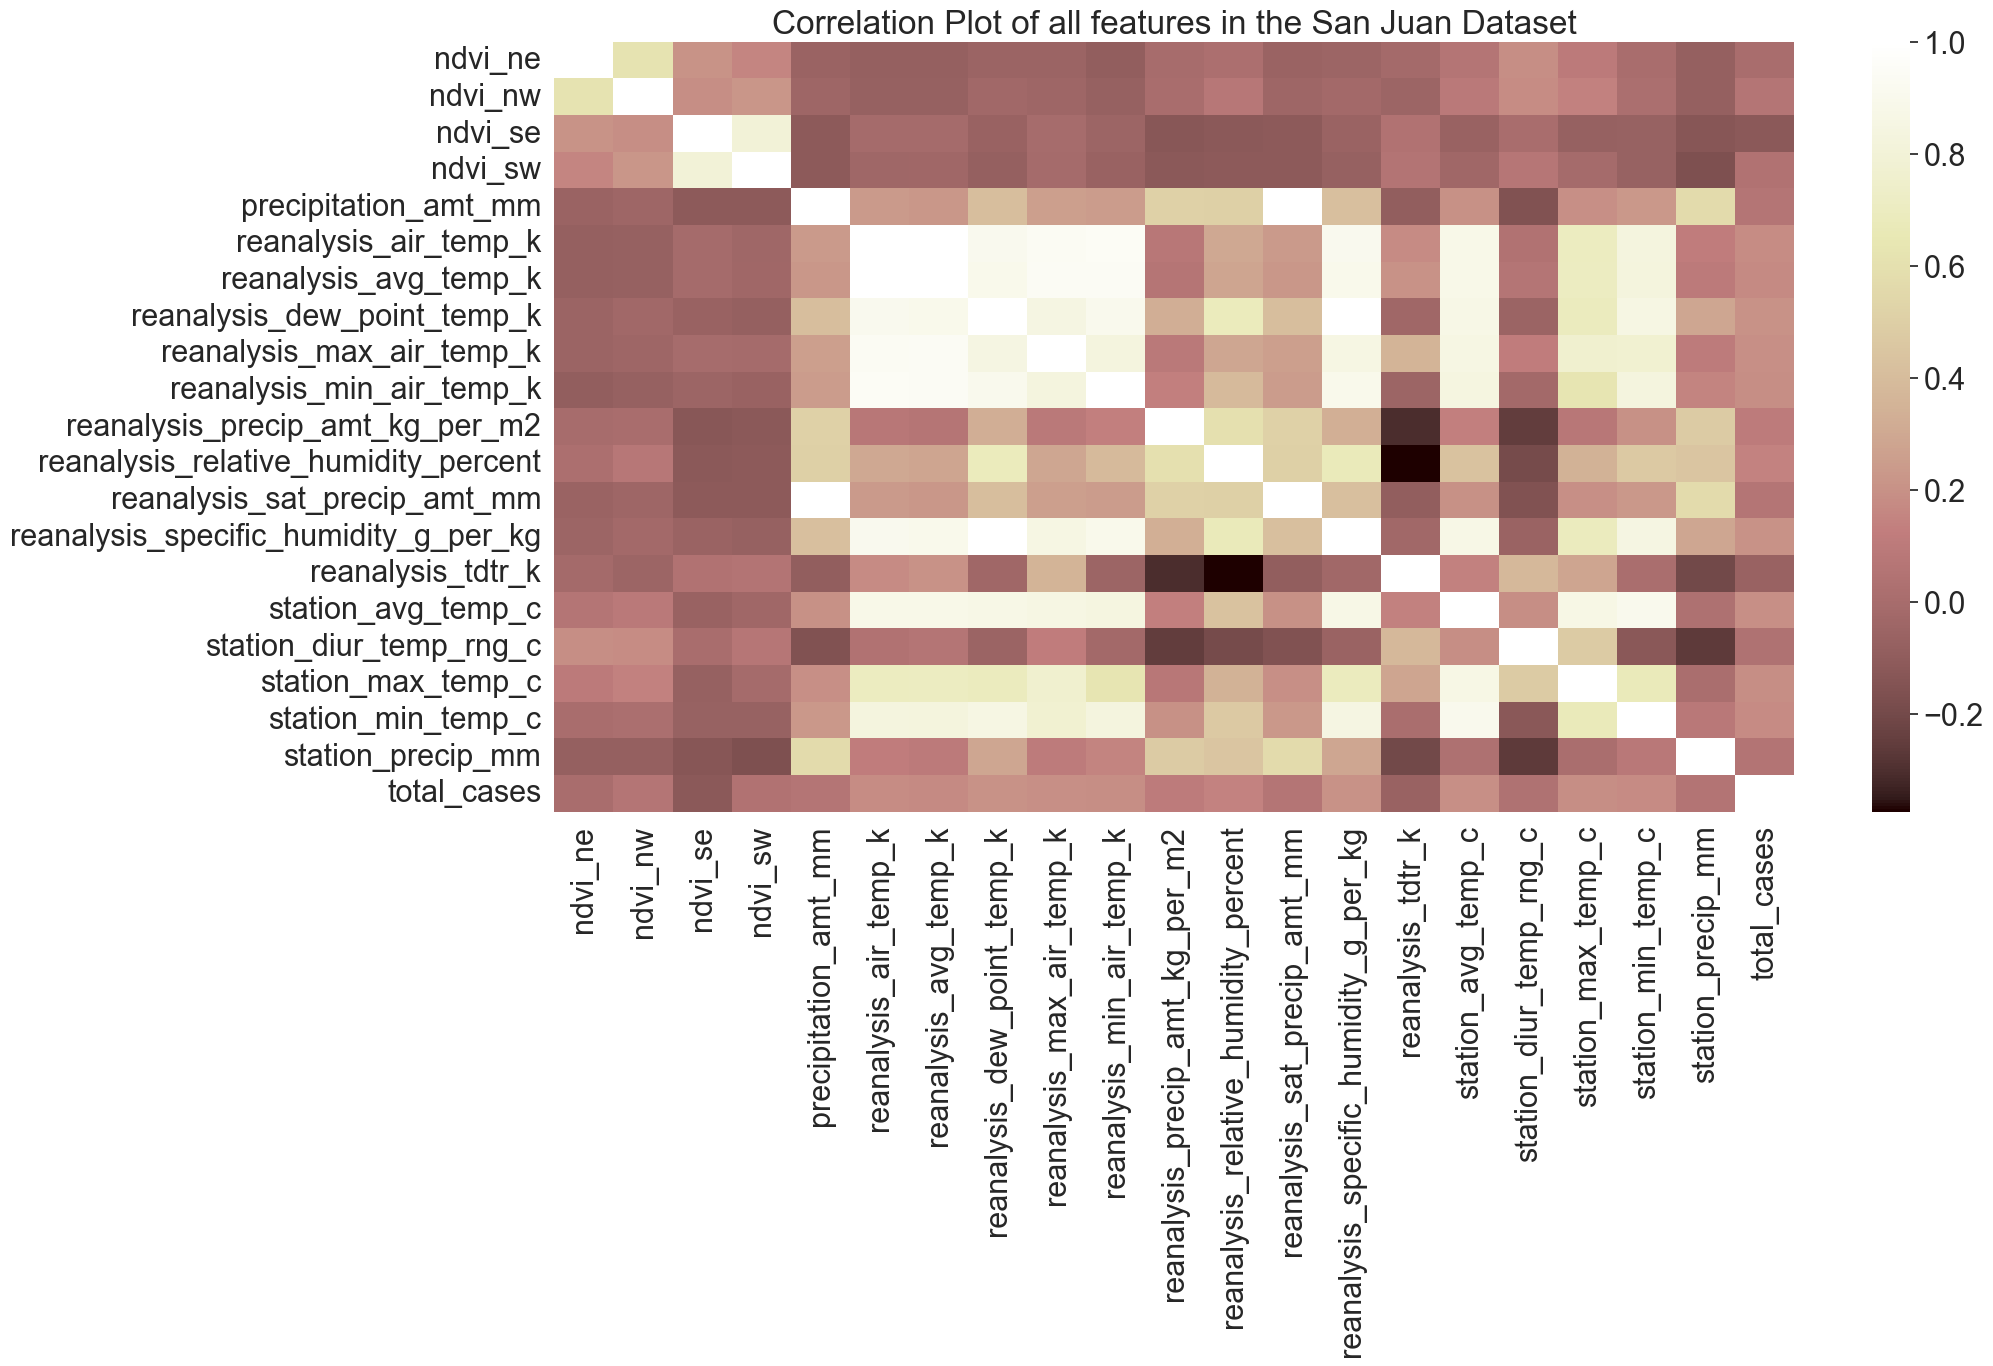

In [88]:
# Calculate correlation
sj_corr = numeric_sj_train_features.corr()

# Plot correlation heatmap with a different color palette
sns.set(font_scale=2)
plt.figure(figsize=(20, 10))
sns.heatmap(sj_corr, cmap='pink')  # Change the colormap to 'coolwarm'
plt.title('Correlation Plot of all features in the San Juan Dataset')
plt.show()


In [ ]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd
import tensorflow as tf

def hill_climbing(x, y, x_test):

    # Evaluating oof predictions
    scores = {}
    for col in x.columns:
        scores[col] = roc_auc_score(y, x[col])

    # Sorting the model scores
    scores = {k: v for k, v in sorted(scores.items(), key=lambda item: item[1], reverse=True)}

    # Sort oof_df and test_preds
    x = x[list(scores.keys())]
    x_test = x_test[list(scores.keys())]

    STOP = False
    current_best_ensemble = x.iloc[:, 0]
    current_best_test_preds = x_test.iloc[:, 0]
    MODELS = x.iloc[:, 1:]
    weight_range = np.arange(-0.5, 0.51, 0.01)
    history = [roc_auc_score(y, current_best_ensemble)]
    j = 0

    while not STOP:
        j += 1
        potential_new_best_cv_score = roc_auc_score(y, current_best_ensemble)
        k_best, wgt_best = None, None
        for k in MODELS:
            for wgt in weight_range:
                potential_ensemble = (1 - wgt) * current_best_ensemble + wgt * MODELS[k]
                cv_score = roc_auc_score(y, potential_ensemble)
                if cv_score > potential_new_best_cv_score:
                    potential_new_best_cv_score = cv_score
                    k_best, wgt_best = k, wgt

        if k_best is not None:
            current_best_ensemble = (1 - wgt_best) * current_best_ensemble + wgt_best * MODELS[k_best]
            current_best_test_preds = (1 - wgt_best) * current_best_test_preds + wgt_best * x_test[k_best]
            MODELS.drop(k_best, axis=1, inplace=True)
            if MODELS.shape[1] == 0:
                STOP = True
            # history.append(potential_new_best_cv_score)
        else:
            STOP = True

    hill_ens_pred_1 = current_best_ensemble
    hill_ens_pred_2 = current_best_test_preds

    return [hill_ens_pred_1, hill_ens_pred_2]


oof_list = pd.DataFrame()
nn_val_predictions = np.zeros((len(X)))

hill_ens_cv_scores, hill_ens_preds = list(), list()

sk = RepeatedStratifiedKFold(n_splits=25, n_repeats=1, random_state=seed)
for i, (train_idx, test_idx) in enumerate(sk.split(X, Y)):

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]

    print('----------------------------------------------------------')

    #####################
    ## Neural Network ##
    ####################

    # Clone the model for which we have already carried out some limited training
    nn_model = tf.keras.models.clone_model(nn_md_start)

    # Model training
    nn_model.compile(
        optimizer=tf.optimizers.Adam(),
        loss='binary_crossentropy',
        metrics=['AUC'])

    nn_model.fit(
        X_train, Y_train,
        epochs=50)

    nn_pred = nn_model.predict(X_test)[:, 0]
    nn_score = roc_auc_score(Y_test, nn_pred)

    print('Fold', i, '==> NN oof ROC-AUC score is ==>', nn_score)

    nn_pred_test = nn_model.predict(test_cv)[:, 0]

    nn_val_predictions[test_idx] += nn_pred
    oof_list['NN'] = nn_val_predictions

    # Your other classifiers here...

    ############################
    ## Hill Climbing Ensemble ##
    ############################

    x = pd.DataFrame({'NN': nn_pred})
    y = Y_test

    x_test = pd.DataFrame({'NN': nn_pred_test})

    hill_results = hill_climbing(x, y, x_test)

    hill_ens_score_fold = roc_auc_score(y, hill_results[0])
    hill_ens_cv_scores.append(hill_ens_score_fold)
    hill_ens_preds.append(hill_results[1])

    print('Fold', i, '==> Hill Climbing Ensemble oof ROC-AUC score is ==>', hill_ens_score_fold)

    print(oof_list)


NameError: name 'X' is not defined

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.metrics import roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
import numpy as np

# Define models
models = [
    ('RF_md', RandomForestClassifier(n_estimators=700, max_depth=10, min_samples_split=20, min_samples_leaf=4, max_samples=0.9, criterion='entropy', bootstrap=True)),
    ('ET_md', ExtraTreesClassifier(n_estimators=700, max_depth=25, min_samples_split=15, min_samples_leaf=1, criterion='gini', bootstrap=True)),
    ('XGB_md', XGBClassifier(objective='binary:logistic', tree_method='hist', colsample_bytree=0.7, gamma=2, learning_rate=0.01, max_depth=7, min_child_weight=10, n_estimators=500, subsample=0.7)),
    ('LGBM_md', LGBMClassifier(objective='binary', n_estimators=500, max_depth=7, learning_rate=0.01, num_leaves=20, reg_alpha=3, reg_lambda=3, subsample=0.7, colsample_bytree=0.7)),
    ('Dart_md', LGBMClassifier(random_state=seed, num_leaves=100, n_estimators=200, min_child_samples=10, max_depth=5, learning_rate=0.1, feature_fraction=0.9, drop_rate=0.4, bagging_freq=3, bagging_fraction=0.6, boosting_type='dart')),
    ('Cat_md', CatBoostClassifier(loss_function='Logloss', iterations=200, learning_rate=0.1, depth=6, bagging_temperature=1.0, border_count=64, l2_leaf_reg=1, verbose=False, task_type='CPU')),
    ('hist_md', HistGradientBoostingClassifier(l2_regularization=0.1, early_stopping=False, learning_rate=0.1, max_iter=400, max_depth=3, max_bins=200, min_samples_leaf=15, max_leaf_nodes=15)),
]

# Carrying out some initial training for the neural network 
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.2, random_state=seed)

nn_md_start = Sequential([
    Input(shape=(X_train.shape[1])),
    Dense(20, activation='relu'),
    Dropout(0.2),
    Dense(15, activation='relu'),
    Dropout(0.2),
    Dense(15, activation='relu'),
    Dropout(0.2),
    Dense(5, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Model training
nn_md_start.compile(
    optimizer=tf.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['AUC']
)

nn_md_start.fit(
    X_train, Y_train,
    epochs=3,
    validation_data=(X_valid, Y_valid),
)

# Predictions
nn_pred_valid = nn_md_start.predict(X_valid)
nn_pred_test = nn_md_start.predict(test_cv)

# Training individual models and get predictions on validation set
individual_model_predictions = {}
for name, model in models:
    model.fit(X_train, Y_train)
    individual_model_predictions[name] = model.predict_proba(X_valid)[:, 1]

# Implement Hill Climbing Ensemble
ensemble_predictions_valid, ensemble_predictions_test = hill_climbing(
    pd.DataFrame(individual_model_predictions), Y_valid, pd.DataFrame(nn_pred_valid), pd.DataFrame(nn_pred_test)
)

# Evaluating Ensemble
ensemble_score_valid = roc_auc_score(Y_valid, ensemble_predictions_valid)
print('Ensemble oof ROC-AUC score is:', ensemble_score_valid)

# Storing ensemble predictions
oof_list['Ensemble'] = ensemble_predictions_valid


NameError: name 'X' is not defined

In [95]:
features_train.head()

week_start_date   ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
city year weekofyear                                                           
sj   1990 18              1990-04-30  0.122600  0.103725  0.198483  0.177617   
          19              1990-05-07  0.169900  0.142175  0.162357  0.155486   
          20              1990-05-14  0.032250  0.172967  0.157200  0.170843   
          21              1990-05-21  0.128633  0.245067  0.227557  0.235886   
          22              1990-05-28  0.196200  0.262200  0.251200  0.247340   

                      precipitation_amt_mm  reanalysis_air_temp_k  \
city year weekofyear                                                
sj   1990 18                         12.42             297.572857   
          19                         22.82             298.211429   
          20                         34.54             298.781429   
          21                         15.36             298.987143   
          22                          7.52             299.518571   

                      reanalysis_avg_temp_k  reanalysis_dew_point_temp_k  \
city year weekofyear                                                       
sj   1990 18                     297.742857                   292.414286   
          19                     298.442857                   293.951429   
          20                     298.878571                   295.434286   
          21                     299.228571                   295.310000   
          22                     299.664286                   295.821429   

                      reanalysis_max_air_temp_k  ...  \
city year weekofyear                             ...   
sj   1990 18                              299.8  ...   
          19                              300.9  ...   
          20                              300.5  ...   
          21                              301.4  ...   
          22                              301.9  ...   

                      reanalysis_precip_amt_kg_per_m2  \
city year weekofyear                                    
sj   1990 18                                    32.00   
          19                                    17.94   
          20                                    26.10   
          21                                    13.90   
          22                                    12.20   

                      reanalysis_relative_humidity_percent  \
city year weekofyear                                         
sj   1990 18                                     73.365714   
          19                                     77.368571   
          20                                     82.052857   
          21                                     80.337143   
          22                                     80.460000   

                      reanalysis_sat_precip_amt_mm  \
city year weekofyear                                 
sj   1990 18                                 12.42   
          19                                 22.82   
          20                                 34.54   
          21                                 15.36   
          22                                  7.52   

                      reanalysis_specific_humidity_g_per_kg  \
city year weekofyear                                          
sj   1990 18                                      14.012857   
          19                                      15.372857   
          20                                      16.848571   
          21                                      16.672857   
          22                                      17.210000   

                      reanalysis_tdtr_k  station_avg_temp_c  \
city year weekofyear                                          
sj   1990 18                   2.628571           25.442857   
          19                   2.371429           26.714286   
          20                   2.300000           26.714286   
          21                   2.428571           27.471429   
          22    

In [96]:
labels_train.head()

total_cases
city year weekofyear             
sj   1990 18                    4
          19                    5
          20                    4
          21                    3
          22                    6

In [97]:
features_train.head()

week_start_date   ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
city year weekofyear                                                           
sj   1990 18              1990-04-30  0.122600  0.103725  0.198483  0.177617   
          19              1990-05-07  0.169900  0.142175  0.162357  0.155486   
          20              1990-05-14  0.032250  0.172967  0.157200  0.170843   
          21              1990-05-21  0.128633  0.245067  0.227557  0.235886   
          22              1990-05-28  0.196200  0.262200  0.251200  0.247340   

                      precipitation_amt_mm  reanalysis_air_temp_k  \
city year weekofyear                                                
sj   1990 18                         12.42             297.572857   
          19                         22.82             298.211429   
          20                         34.54             298.781429   
          21                         15.36             298.987143   
          22                          7.52             299.518571   

                      reanalysis_avg_temp_k  reanalysis_dew_point_temp_k  \
city year weekofyear                                                       
sj   1990 18                     297.742857                   292.414286   
          19                     298.442857                   293.951429   
          20                     298.878571                   295.434286   
          21                     299.228571                   295.310000   
          22                     299.664286                   295.821429   

                      reanalysis_max_air_temp_k  ...  \
city year weekofyear                             ...   
sj   1990 18                              299.8  ...   
          19                              300.9  ...   
          20                              300.5  ...   
          21                              301.4  ...   
          22                              301.9  ...   

                      reanalysis_precip_amt_kg_per_m2  \
city year weekofyear                                    
sj   1990 18                                    32.00   
          19                                    17.94   
          20                                    26.10   
          21                                    13.90   
          22                                    12.20   

                      reanalysis_relative_humidity_percent  \
city year weekofyear                                         
sj   1990 18                                     73.365714   
          19                                     77.368571   
          20                                     82.052857   
          21                                     80.337143   
          22                                     80.460000   

                      reanalysis_sat_precip_amt_mm  \
city year weekofyear                                 
sj   1990 18                                 12.42   
          19                                 22.82   
          20                                 34.54   
          21                                 15.36   
          22                                  7.52   

                      reanalysis_specific_humidity_g_per_kg  \
city year weekofyear                                          
sj   1990 18                                      14.012857   
          19                                      15.372857   
          20                                      16.848571   
          21                                      16.672857   
          22                                      17.210000   

                      reanalysis_tdtr_k  station_avg_temp_c  \
city year weekofyear                                          
sj   1990 18                   2.628571           25.442857   
          19                   2.371429           26.714286   
          20                   2.300000           26.714286   
          21                   2.428571           27.471429   
          22    

In [98]:
submission.head()

,city,year,weekofyear,total_cases
0,sj,2008,18,0
1,sj,2008,19,0
2,sj,2008,20,0
3,sj,2008,21,0
4,sj,2008,22,0


In [ ]:
# Step 1: Merging features and labels datasets
merged_data = pd.merge(features_train, labels_train, on=['city', 'year', 'weekofyear'])

# Step 2: Defining X (features) and Y (target variable)
X = merged_data.drop(['total_cases', 'week_start_date'], axis=1)  # Exclude 'total_cases' and 'week_start_date' from features
Y = merged_data['total_cases']

# Step 3: Data Preprocessing (handle missing values, categorical encoding, etc.)

# Step 4: Modeling Training and Evaluation
# Train your classification models using X and Y


In [100]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

In [101]:
missing_values = X.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 ndvi_ne                                  194
ndvi_nw                                   52
ndvi_se                                   22
ndvi_sw                                   22
precipitation_amt_mm                      13
reanalysis_air_temp_k                     10
reanalysis_avg_temp_k                     10
reanalysis_dew_point_temp_k               10
reanalysis_max_air_temp_k                 10
reanalysis_min_air_temp_k                 10
reanalysis_precip_amt_kg_per_m2           10
reanalysis_relative_humidity_percent      10
reanalysis_sat_precip_amt_mm              13
reanalysis_specific_humidity_g_per_kg     10
reanalysis_tdtr_k                         10
station_avg_temp_c                        43
station_diur_temp_rng_c                   43
station_max_temp_c                        20
station_min_temp_c                        14
station_precip_mm                         22
dtype: int64


In [102]:
X.fillna(X.mean(), inplace=True)

C:\Users\Oscar\AppData\Local\Temp\ipykernel_23392\642802493.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  X.fillna(X.mean(), inplace=True)


In [103]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [104]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, Y_train)

RandomForestRegressor(random_state=42)

In [105]:
train_predictions = rf_model.predict(X_train)

In [106]:
test_predictions = rf_model.predict(X_test)

In [107]:
train_mae = mean_absolute_error(Y_train, train_predictions)
test_mae = mean_absolute_error(Y_test, test_predictions)

print("Training MAE:", train_mae)
print("Testing MAE:", test_mae)

Training MAE: 6.605566028473246
Testing MAE: 22.15141654435747


In [109]:
print("Features used during training:", rf_model.feature_names_in_)
print("Columns in submission data:", submission_data.columns)

Features used during training: ['ndvi_ne' 'ndvi_nw' 'ndvi_se' 'ndvi_sw' 'precipitation_amt_mm'
 'reanalysis_air_temp_k' 'reanalysis_avg_temp_k'
 'reanalysis_dew_point_temp_k' 'reanalysis_max_air_temp_k'
 'reanalysis_min_air_temp_k' 'reanalysis_precip_amt_kg_per_m2'
 'reanalysis_relative_humidity_percent' 'reanalysis_sat_precip_amt_mm'
 'reanalysis_specific_humidity_g_per_kg' 'reanalysis_tdtr_k'
 'station_avg_temp_c' 'station_diur_temp_rng_c' 'station_max_temp_c'
 'station_min_temp_c' 'station_precip_mm']
Columns in submission data: Index(['city', 'year', 'weekofyear', 'total_cases', 'ndvi_ne', 'ndvi_nw',
       'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_t

In [110]:
submission_data = submission_data[X_train.columns]

In [112]:
submission_predictions = rf_model.predict(submission_data)

ValueError: Found array with 0 sample(s) (shape=(0, 20)) while a minimum of 1 is required by RandomForestRegressor.

In [108]:
submission_data = pd.merge(submission, features_train, on=['city', 'year', 'weekofyear'])
submission_data = submission_data.drop('week_start_date', axis=1)
submission_predictions = rf_model.predict(submission_data)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- city
- total_cases
- weekofyear
- year
